In [24]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference, false_positive_rate, false_negative_rate
import warnings
warnings.filterwarnings('ignore')

In [72]:
# loading the data
X = pd.read_csv("acsincome_ca_features.csv")
y = pd.read_csv("acsincome_ca_labels.csv")
X.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0


In [73]:
# checking for missing values
print(X.isnull().sum())
print(y.isnull().sum())

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


In [74]:
# shuffle the data, select 10%
X, y = shuffle(X, y, random_state=1)

num_samples = int(len(X)*0.1)
X, y = X[:num_samples], y[:num_samples]

print(X.shape)
print(y.shape)

(19566, 10)
(19566, 1)


In [75]:
# Standrize and split the data
scaler = StandardScaler()
scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [6]:
param_grid_SVC = {
    'C': [0.1, 1, 10, 50, 100],
    'kernel': ['rbf']
}
param_grid_randomF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],                   
    'learning_rate': [0.01, 0.1, 1.0, 2.0]
}
param_grid_gradientboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}

models = []
models.append(('SVM', SVR(), param_grid_SVC))
models.append(('RF', RandomForestClassifier(), param_grid_randomF))
models.append(('AB', AdaBoostClassifier(), param_grid_adaboost))
models.append(('GB', GradientBoostingClassifier(), param_grid_gradientboost))

In [7]:
names = []
best_estimators = []
best_hyperparams = []
best_scores = []

for name, model, params in models:
    print( ">> GridSearch of {} in progress ...".format(name))
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=5)
    grid_search.fit(X_train,y_train)
    names.append(name)
    best_estimators.append(grid_search.best_estimator_)
    best_hyperparams.append(grid_search.best_params_)
    best_scores.append(grid_search.best_score_)

>> GridSearch of SVM in progress ...


>> GridSearch of RF in progress ...
>> GridSearch of AB in progress ...
>> GridSearch of GB in progress ...


In [8]:
df = pd.DataFrame({
    'Model': names,
    'Best estimator': best_estimators,
    'Best hyperparameters': best_hyperparams,
    'Best score': best_scores
})
display(df)

,Model,Best estimator,Best hyperparameters,Best score
0,SVM,SVR(C=0.1),"{'C': 0.1, 'kernel': 'rbf'}",NaN
1,RF,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.810502
2,AB,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 1.0, 'n_estimators': 200}",0.811909
3,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.818617


In [9]:
train_scores = []
train_mean_scores = []
train_std_deviation = []

test_scores = []
test_mean_scores = []
test_std_deviation = []

for model in best_estimators:
    train_result = cross_val_score(model, X_train, y_train, cv=5)
    train_scores.append(train_result)
    train_mean_scores.append(round(train_result.mean(), 2))
    train_std_deviation.append(round(train_result.std(), 3))

    test_result = cross_val_score(model, X_test, y_test, cv=5)
    test_scores.append(test_result)
    test_mean_scores.append(round(test_result.mean(), 2))
    test_std_deviation.append(round(test_result.std(), 3))

data = pd.DataFrame({
    'Model': names,
    'Train mean': train_mean_scores,
    'Train std': train_std_deviation,
    'Test mean': test_mean_scores,
    'Test std': test_std_deviation
})

display(data)

,Model,Train mean,Train std,Test mean,Test std
0,SVM,0.08,0.017,0.05,0.038
1,RF,0.81,0.008,0.80,0.006
2,AB,0.81,0.006,0.81,0.009
3,GB,0.82,0.005,0.80,0.010


<Axes: xlabel='Model'>

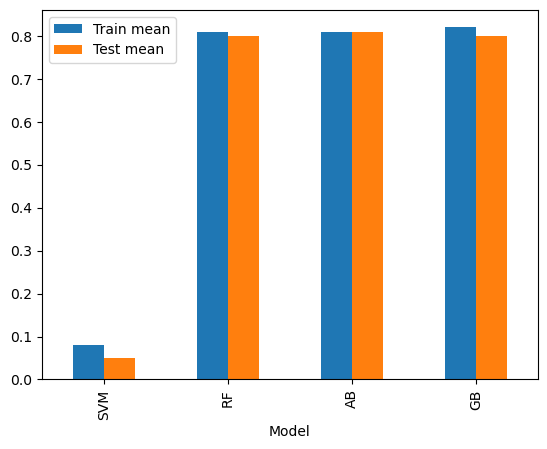

In [10]:
data.plot(
    x='Model',
    y=['Train mean','Test mean'], 
    kind='bar'
) 

In [11]:
def plot_confusion_matrix(cm) :
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

>> SVM
Accuracy score :  0.6939192641798672
Classification report :
               precision    recall  f1-score   support

       False       0.70      0.82      0.76      2270
        True       0.68      0.52      0.59      1644

    accuracy                           0.69      3914
   macro avg       0.69      0.67      0.67      3914
weighted avg       0.69      0.69      0.69      3914



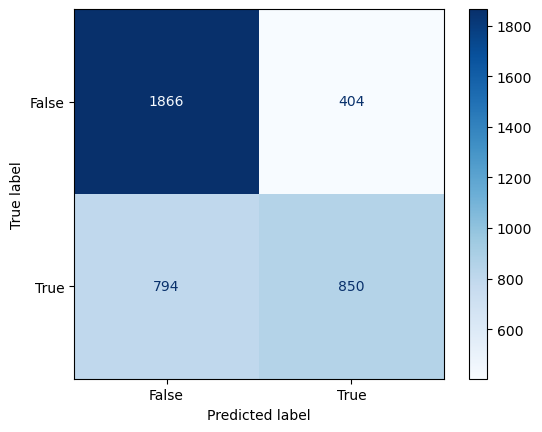

>> RF
Accuracy score :  0.8160449667858968
Classification report :
               precision    recall  f1-score   support

       False       0.83      0.86      0.84      2270
        True       0.79      0.76      0.78      1644

    accuracy                           0.82      3914
   macro avg       0.81      0.81      0.81      3914
weighted avg       0.82      0.82      0.82      3914



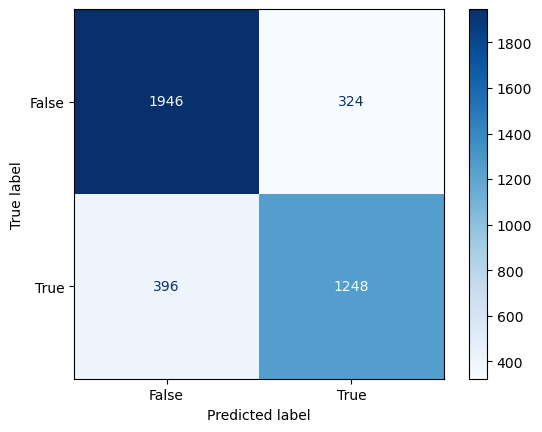

>> AB
Accuracy score :  0.8170669391926418
Classification report :
               precision    recall  f1-score   support

       False       0.84      0.85      0.84      2270
        True       0.79      0.78      0.78      1644

    accuracy                           0.82      3914
   macro avg       0.81      0.81      0.81      3914
weighted avg       0.82      0.82      0.82      3914



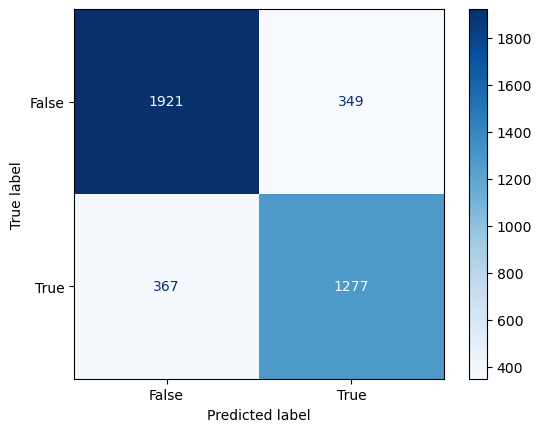

>> GB
Accuracy score :  0.8234542667347982
Classification report :
               precision    recall  f1-score   support

       False       0.84      0.86      0.85      2270
        True       0.80      0.78      0.79      1644

    accuracy                           0.82      3914
   macro avg       0.82      0.82      0.82      3914
weighted avg       0.82      0.82      0.82      3914



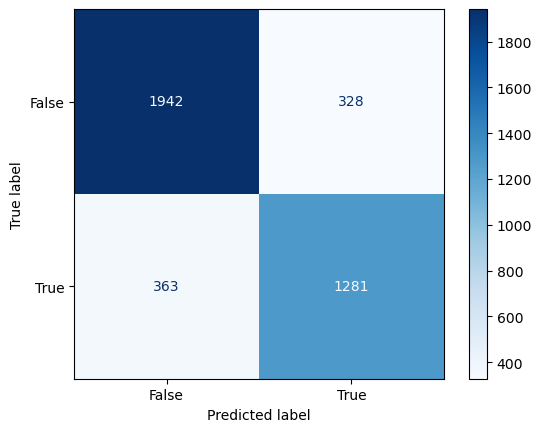

In [12]:
accuracy_scores = []
y_pred_ca_dataset = []
for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_test)
    y_pred_ca_dataset.append(y_pred)
    acc_score = accuracy_score(y_test, y_pred.round())
    accuracy_scores.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_test, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred.round()))


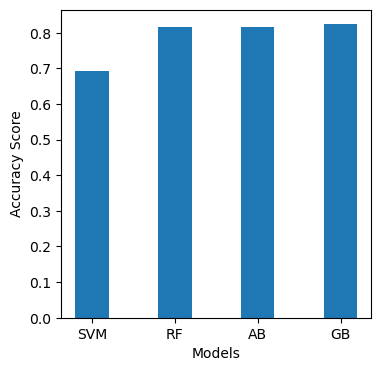

In [13]:
plt.figure(figsize=(4, 4))
plt.bar(names, accuracy_scores, width=0.4)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')  
plt.show()

KeyboardInterrupt: 

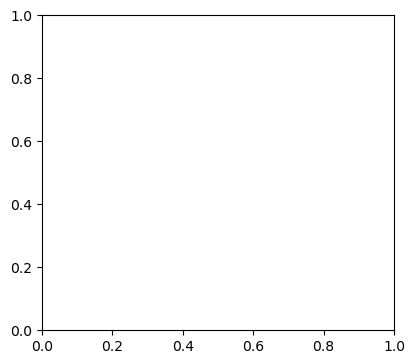

In [14]:
# Use learning curve to get training and test scores along with train sizes
plt.figure(figsize=(10,9))

for index, model in enumerate(best_estimators):
    plt.subplot(2,2,index+1)
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, 
                                                            cv=5, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(names[index], fontsize=10)
    plt.xlabel('Training data size', fontsize=8)
    plt.ylabel('Model accuracy', fontsize=8)
    plt.grid()
    plt.legend(loc='lower right', fontsize=8)
plt.show()

In [ ]:
# ################################################################################################################## 

In [ ]:
# ############# COLORADO DATASET ###################
X_co = pd.read_csv("acsincome_co_allfeaturesTP2.csv")
y_co = pd.read_csv("acsincome_co_labelTP2.csv")

# checking for missing values
print(X_co.isnull().sum())
print(y_co.isnull().sum())

# shuffle the data, select 10%
X_co, y_co = shuffle(X_co, y_co, random_state=1)
num_samples_ = int(len(X_co)*0.1)
X_co, y_co = X_co[:num_samples], y_co[:num_samples]

# Standrize the data
scaler_co = StandardScaler()
scaler_co.fit_transform(X_co)

X_co.head()

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
12591,40.0,1.0,18.0,1.0,110.0,18.0,1.0,40.0,1.0,1.0
1463,21.0,1.0,19.0,1.0,3930.0,8.0,0.0,20.0,2.0,1.0
9624,53.0,3.0,21.0,1.0,2545.0,8.0,0.0,25.0,2.0,1.0
19904,28.0,1.0,21.0,5.0,1305.0,8.0,0.0,45.0,2.0,1.0
5504,17.0,1.0,14.0,5.0,5240.0,8.0,3.0,24.0,2.0,1.0


>> COLORADO DATASET
>> SVM
Accuracy score :  0.6748952264131657
Classification report :
               precision    recall  f1-score   support

           0       0.70      0.77      0.74     11480
           1       0.62      0.54      0.58      8086

    accuracy                           0.67     19566
   macro avg       0.66      0.65      0.66     19566
weighted avg       0.67      0.67      0.67     19566



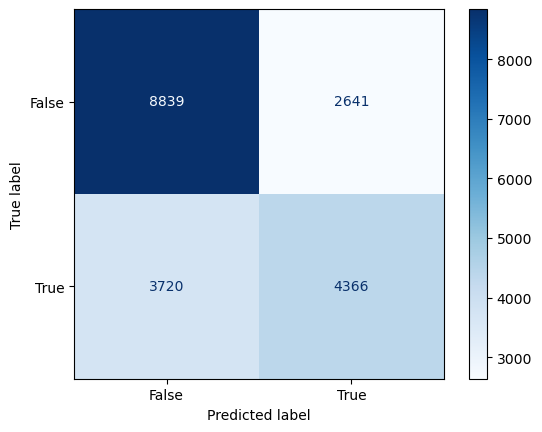

>> RF
Accuracy score :  0.7708269446999898
Classification report :
               precision    recall  f1-score   support

           0       0.85      0.74      0.79     11480
           1       0.69      0.82      0.75      8086

    accuracy                           0.77     19566
   macro avg       0.77      0.78      0.77     19566
weighted avg       0.78      0.77      0.77     19566



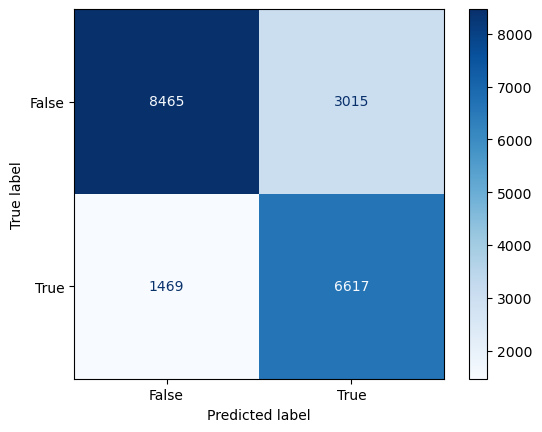

>> AB
Accuracy score :  0.7733312889706634
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.72      0.79     11480
           1       0.68      0.85      0.76      8086

    accuracy                           0.77     19566
   macro avg       0.78      0.78      0.77     19566
weighted avg       0.79      0.77      0.78     19566



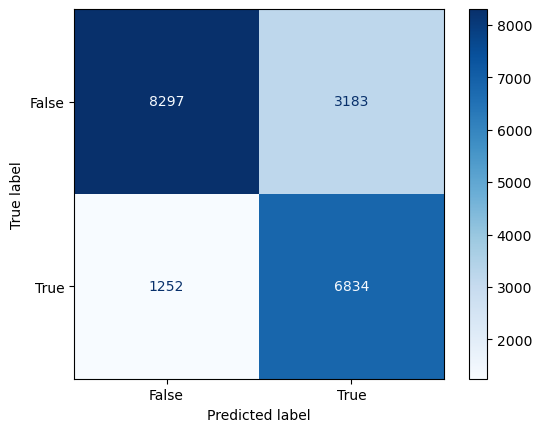

>> GB
Accuracy score :  0.7780844321782684
Classification report :
               precision    recall  f1-score   support

           0       0.86      0.74      0.80     11480
           1       0.69      0.84      0.76      8086

    accuracy                           0.78     19566
   macro avg       0.78      0.79      0.78     19566
weighted avg       0.79      0.78      0.78     19566



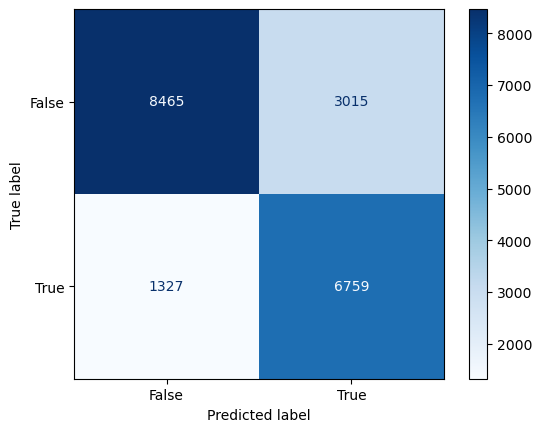

In [ ]:
print(">> COLORADO DATASET")
accuracy_scores_co = []

for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_co)
    acc_score = accuracy_score(y_co, y_pred.round())
    accuracy_scores_co.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_co, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_co, y_pred.round()))

In [ ]:
# ############# NEVADA DATASET ###################
X_ne = pd.read_csv("acsincome_ne_allfeaturesTP2.csv")
y_ne = pd.read_csv("acsincome_ne_labelTP2.csv")

# checking for missing values
print(X_ne.isnull().sum())
print(y_ne.isnull().sum())

# shuffle the data, select 10%
X_ne, y_ne = shuffle(X_ne, y_ne, random_state=1)
num_samples_ = int(len(X_ne)*0.1)
X_ne, y_ne = X_ne[:num_samples], y_ne[:num_samples]

# Standrize the data
scaler_ne = StandardScaler()
scaler_ne.fit_transform(X_ne)

X_ne.head()

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
5051,57.0,1.0,16.0,1.0,7810.0,303.0,0.0,40.0,1.0,1.0
9180,39.0,1.0,21.0,1.0,4600.0,19.0,0.0,35.0,2.0,1.0
5547,59.0,1.0,20.0,1.0,2300.0,19.0,0.0,40.0,2.0,1.0
9040,47.0,3.0,16.0,3.0,9620.0,31.0,0.0,35.0,1.0,1.0
6025,36.0,4.0,18.0,5.0,3802.0,31.0,15.0,50.0,1.0,1.0


>> NEVADA DATASET
>> SVM
Accuracy score :  0.6989337042188224
Classification report :
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      7417
           1       0.52      0.46      0.49      3368

    accuracy                           0.70     10785
   macro avg       0.64      0.63      0.64     10785
weighted avg       0.69      0.70      0.69     10785



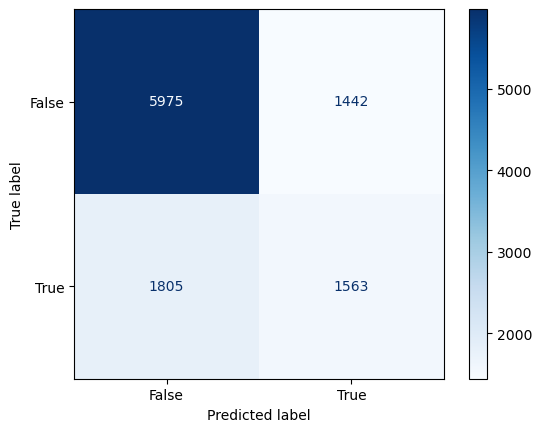

>> RF
Accuracy score :  0.7391747797867408
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      7417
           1       0.56      0.82      0.66      3368

    accuracy                           0.74     10785
   macro avg       0.73      0.76      0.73     10785
weighted avg       0.79      0.74      0.75     10785



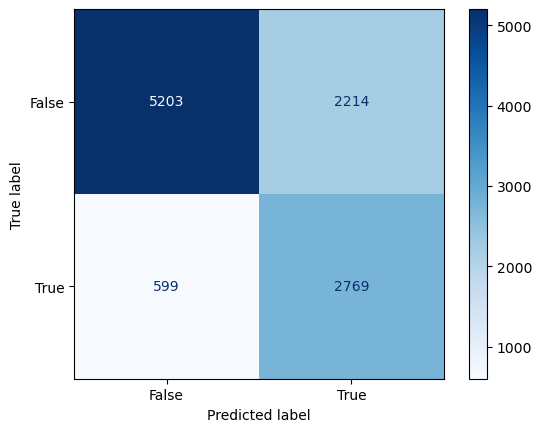

>> AB
Accuracy score :  0.7366713027352805
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.69      0.78      7417
           1       0.55      0.85      0.67      3368

    accuracy                           0.74     10785
   macro avg       0.73      0.77      0.73     10785
weighted avg       0.80      0.74      0.75     10785



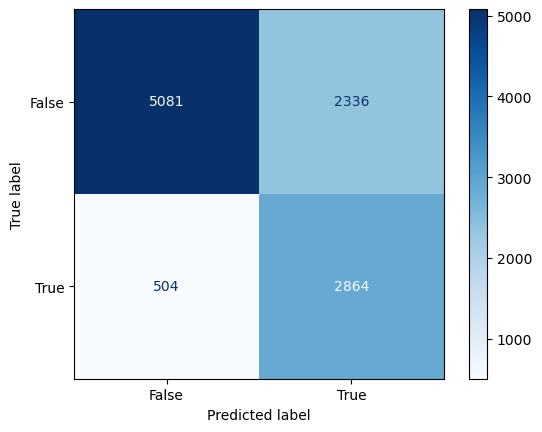

>> GB
Accuracy score :  0.7426054705609643
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      7417
           1       0.56      0.83      0.67      3368

    accuracy                           0.74     10785
   macro avg       0.73      0.77      0.73     10785
weighted avg       0.79      0.74      0.75     10785



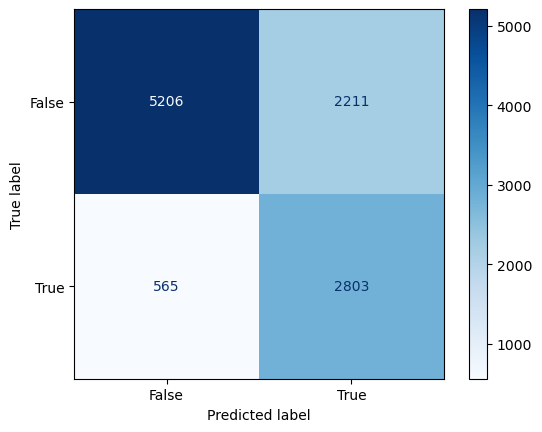

In [ ]:
print(">> NEVADA DATASET")
accuracy_scores_ne = []

for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_ne)
    acc_score = accuracy_score(y_ne, y_pred.round())
    accuracy_scores_ne.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_ne, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_ne, y_pred.round()))

,Model,Californir,Colorado,Nevada
0,SVM,0.699029,0.674895,0.698934
1,RF,0.811702,0.770827,0.739175
2,AB,0.816811,0.773331,0.736671
3,GB,0.821410,0.778084,0.742605


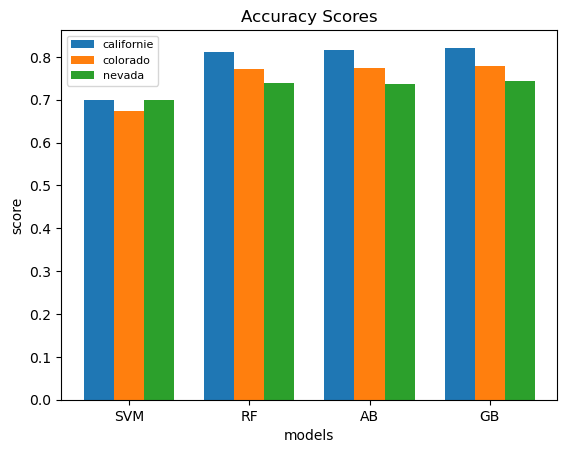

In [ ]:
data = pd.DataFrame({
    'Model': names,
    'Californir': accuracy_scores,
    'Colorado': accuracy_scores_co,
    'Nevada': accuracy_scores_ne
})

display(data)

ind = np.arange(4)  
width = 0.25
  
bar1 = plt.bar(ind, accuracy_scores, width) 
bar2 = plt.bar(ind+width, accuracy_scores_co, width) 
bar3 = plt.bar(ind+width*2, accuracy_scores_ne, width) 
  
plt.xlabel("models") 
plt.ylabel("score") 
plt.title("Accuracy Scores") 
  
plt.xticks(ind+width, names, rotation=0) 
plt.legend((bar1, bar2, bar3), ('californie', 'colorado', 'nevada'), fontsize="8")
plt.show()

In [15]:
######################################## Part : 2 ##################################################

###### 1 : Explicabilité ###########################################
###### a : 
from sklearn.inspection import permutation_importance


xtrain = pd.DataFrame(X_train)
ytrain = pd.DataFrame(y_train)
training_dataset = pd.concat([xtrain, ytrain], axis=1)
correlations = training_dataset.corr()['PINCP'].drop('PINCP')
print(correlations)

###### d : à voir dans le rapport ####################
    







AGEP     0.262384
COW      0.060295
SCHL     0.339452
MAR     -0.282733
OCCP    -0.347177
POBP    -0.080858
RELP    -0.224228
WKHP     0.333718
SEX     -0.112783
RAC1P   -0.102030
Name: PINCP, dtype: float64


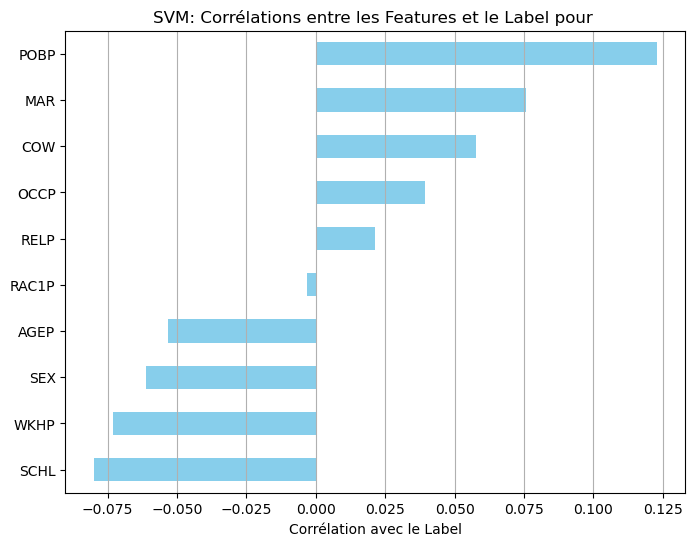

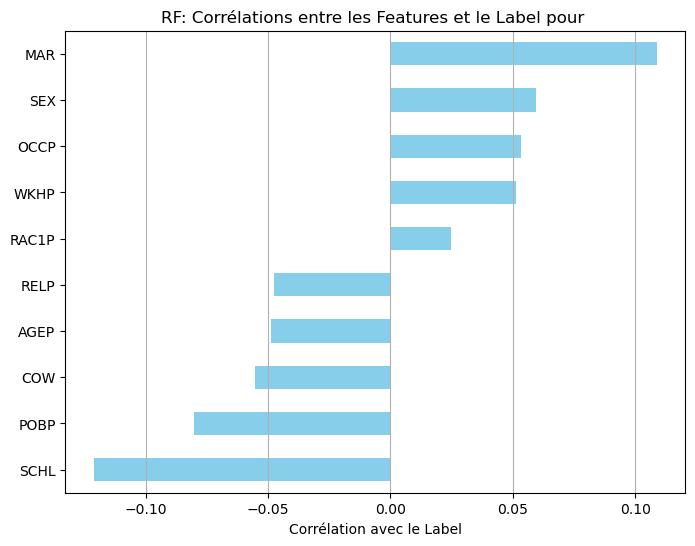

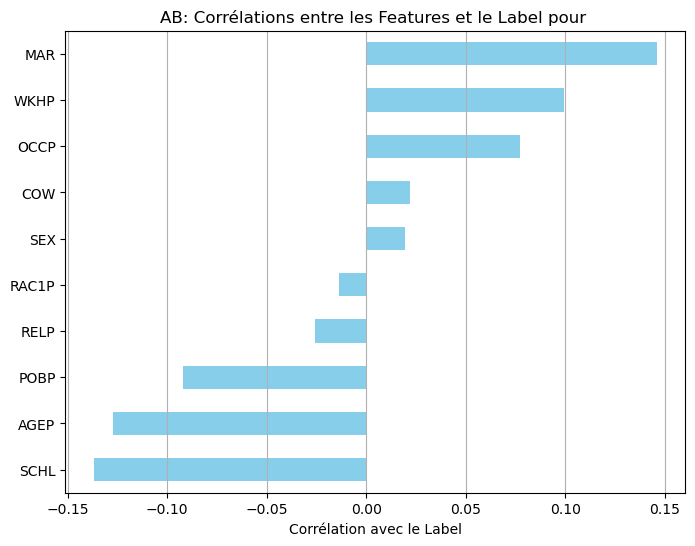

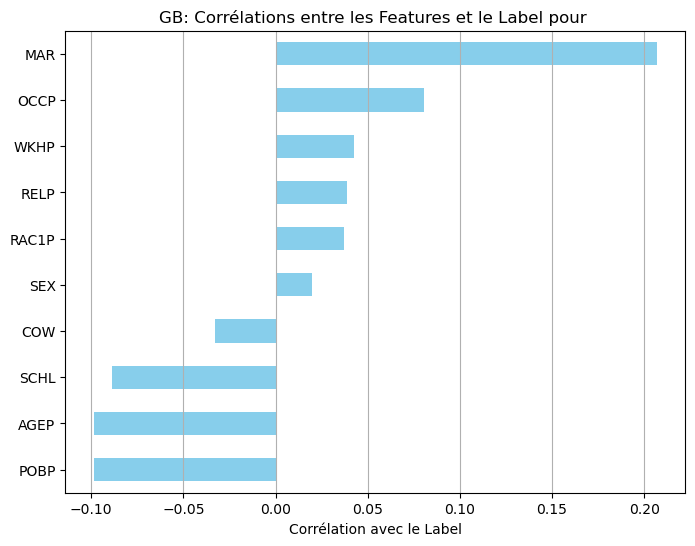

In [ ]:
###### b :
names = ["SVM","RF","AB","GB"]
correlations = []
for predLables in y_pred_ca_dataset:    
    xtest = pd.DataFrame(X_test)
    ypred = pd.DataFrame({'PINCP' : predLables})
    correlations.append(pd.concat([xtest, ypred], axis=1).corr()['PINCP'].drop('PINCP'))

for index, corr in enumerate(correlations):
    plt.figure(figsize=(8, 6))
    corr.sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel('Corrélation avec le Label')
    plt.title(names[index] +": Corrélations entre les Features et le Label pour ")
    plt.grid(axis='x')
    plt.show()
# il faut ajouter la comparaison entre ces corrélations et les corrélations de la question a
    

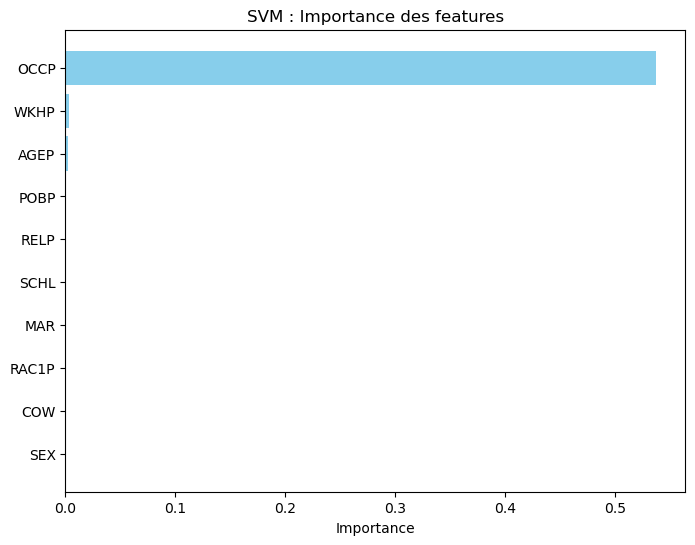

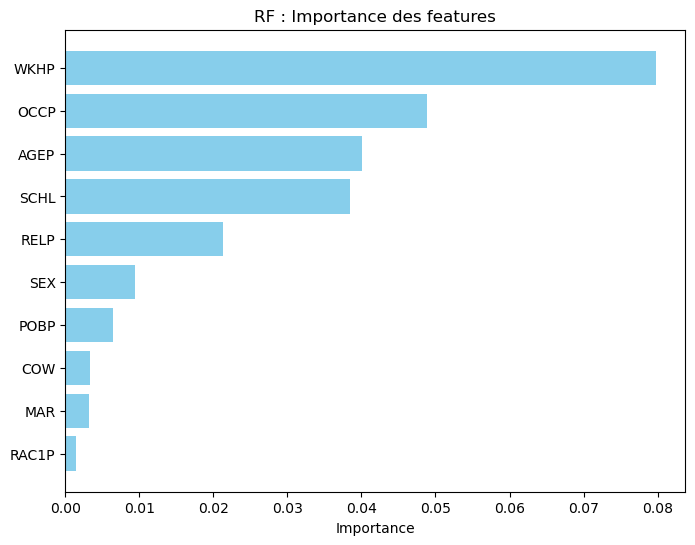

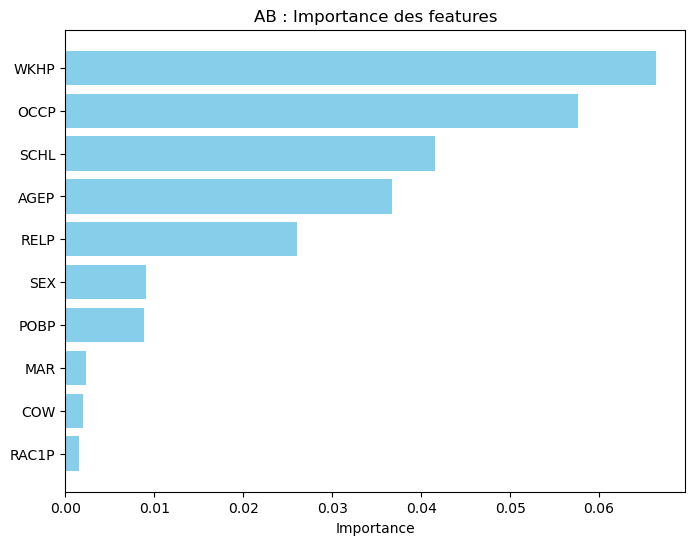

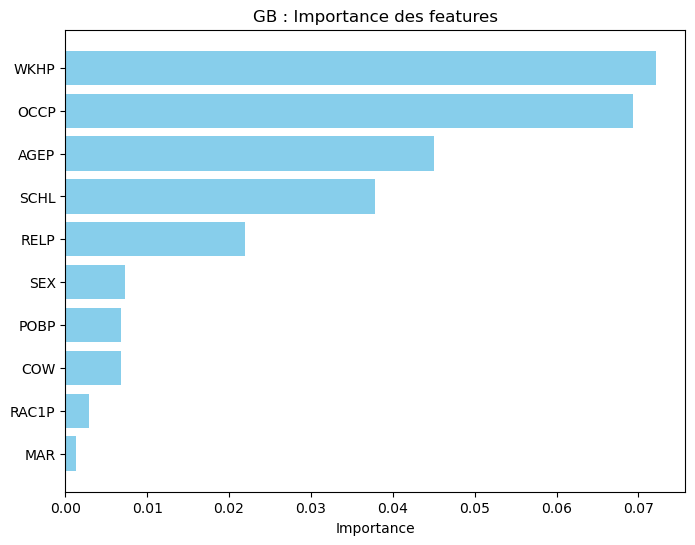

In [ ]:
###### c :
# On récupère l'importance des features pour chaque modèle et on les plot(pour chaque modèle)
for index, model in enumerate(best_estimators):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean
    feature_names = X_test.columns
    # Affichage des importances des features dans un graphique
    plt.figure(figsize=(8, 6))
    sorted_idx = importance.argsort()
    plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center', color='skyblue')
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])  # Utilisation des vrais noms de features
    plt.xlabel('Importance')
    plt.title(names[index] +" : Importance des features")
    plt.show()

In [ ]:
###### d : à voir dans le rapport ####################

m  5691   5691
f  5094   5094
>> SVM
la matrice de confusion pour les hommes


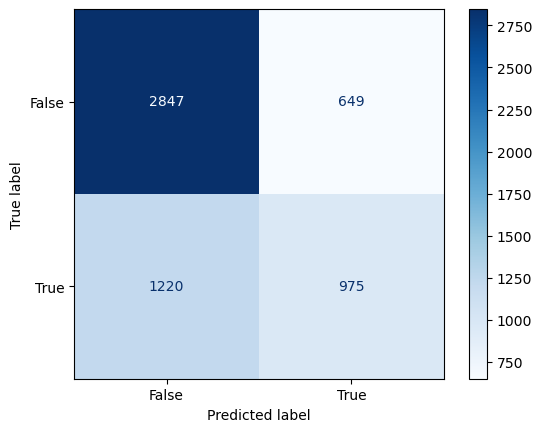

la matrice de confusion pour les femmes


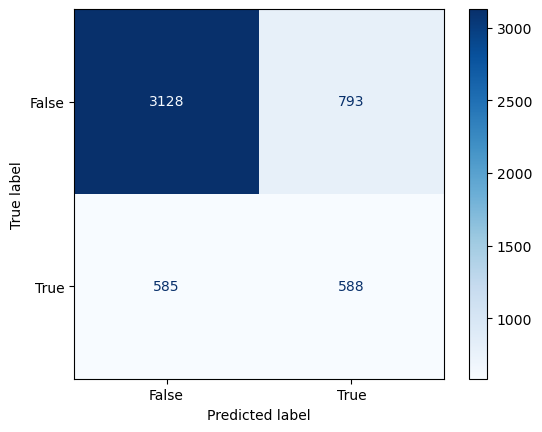

>> RF
la matrice de confusion pour les hommes


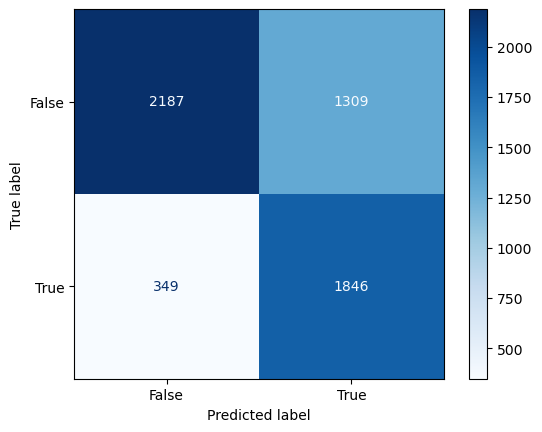

la matrice de confusion pour les femmes


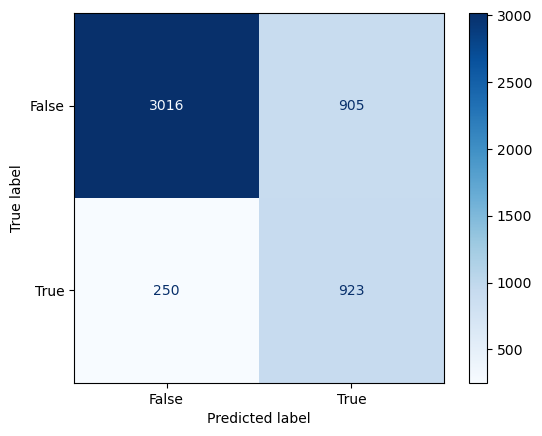

>> AB
la matrice de confusion pour les hommes


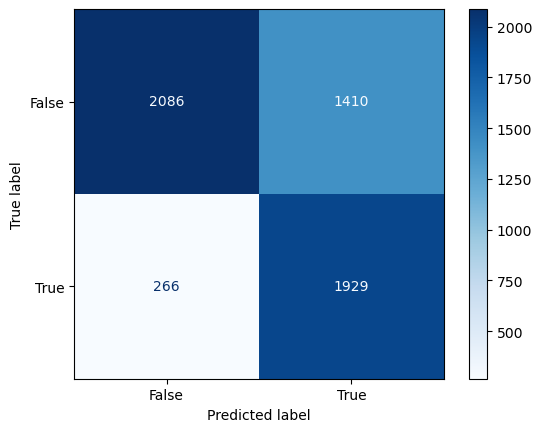

la matrice de confusion pour les femmes


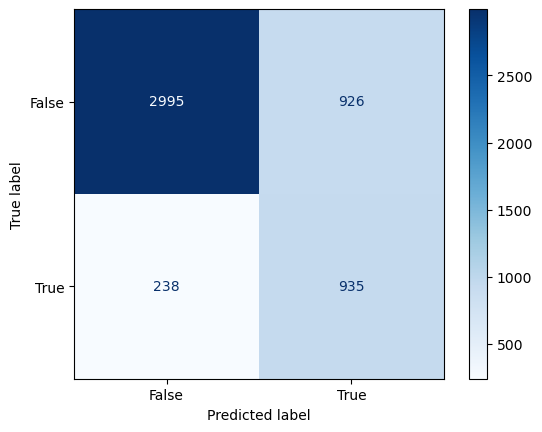

>> GB
la matrice de confusion pour les hommes


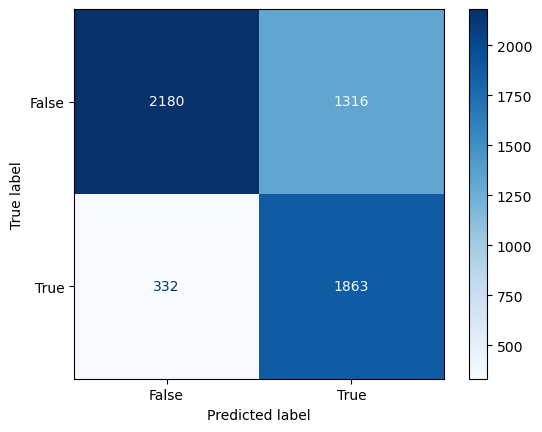

la matrice de confusion pour les femmes


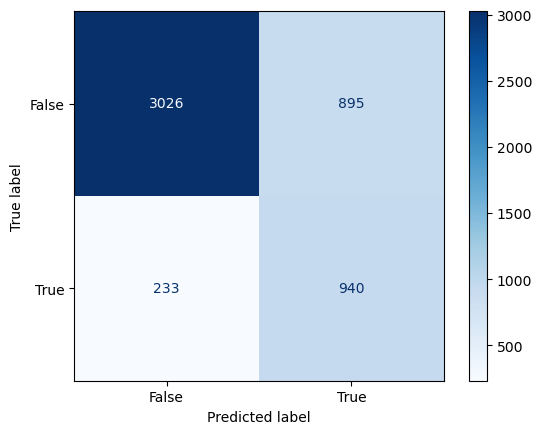

In [ ]:
###### 2 : Equité des modèles ###########################################
###### a :
###### diviser le dataset en deux groupes par apport au SEX(male group et female group)
dataset = pd.concat([X_ne, y_ne], axis=1)

male_group_dataset = dataset[dataset['SEX'] == 1.0]
female_group_dataset = dataset[dataset['SEX'] == 2.0]

y_ne_male = male_group_dataset[['PINCP']].copy()
y_ne_female = female_group_dataset[['PINCP']].copy()

X_ne_male = male_group_dataset.drop('PINCP', axis=1)
X_ne_female = female_group_dataset.drop('PINCP', axis=1)

print("m ",len(X_ne_male)," ",len(y_ne_male))
print("f ",len(X_ne_female)," ",len(y_ne_female))

for index, best_model in enumerate(best_estimators):
    print(">> {}".format(names[index]))
    print("la matrice de confusion pour les hommes")
    y_pred_male = best_model.predict(X_ne_male)
    plot_confusion_matrix(confusion_matrix(y_ne_male, y_pred_male.round()))
    print("la matrice de confusion pour les femmes")
    y_pred_female = best_model.predict(X_ne_female)
    plot_confusion_matrix(confusion_matrix(y_ne_female, y_pred_female.round()))


In [47]:
####### b: 
####### On va utiliser la métrique "Partitionner en fonction d'attributs sensibles" et la métrique "Métrique parité statistique" \
####### comme métriques d’équité statistique
####### Pour cela, on va utiliser la bibliothèque fairlearn de python (pour l'installer : pip install fairlean)

######################################## commentaires : ########################################################
# equalized_odds_difference : permet d'évaluer l'équité du modèle en mesurant la différence d'égalité des chances entre différents
# groupes définis par des attributs sensibles. Elle est utilisée pour évaluer si le modèle présente des disparités dans les performances
# de prédiction entre ces groupes, en se concentrant sur l'équité des résultats prédits.

#################################" Interprétation des résultats (equalized_odds_difference): ################### 
# Analysez la valeur obtenue pour la différence d'égalité des chances. Une valeur proche de zéro indique une égalité des chances équitable
# entre les groupes, tandis qu'une valeur éloignée de zéro suggère des disparités dans les performances du modèle entre ces groupes.

# selection_rate : est utilisée pour évaluer le taux de sélection pour différents groupes définis par des attributs sensibles.
# Elle permet de calculer ce taux pour chaque groupe spécifique afin d'évaluer s'il y a des disparités dans les sélections effectuées 
# par le modèle entre ces groupes
#################################" Interprétation des résultats (selection_rate): ##############################
# il faut examiner les taux de sélection pour chaque groupe pour comprendre s'il existe des différences significatives dans la manière
# dont le modèle effectue des sélections entre ces groupes.

for index, best_model in enumerate(best_estimators):
    print(">> {}".format(names[index]))
    # selection_rate : Pour le training
    print("selection_rate : en train")
    y_pred_train = best_model.predict(X_train)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_train, y_pred=y_pred_train, sensitive_features=X_train['SEX'])
    print(metric_frame.by_group)
    
    # selection_rate : Pour le test
    print("selection_rate : en test")
    y_pred_test = best_model.predict(X_test)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_test, y_pred=y_pred_test, sensitive_features=X_test['SEX'])
    print(metric_frame.by_group)

    
    # equalized_odds_difference : Pour le training
    print("equalized_odds_difference : en train")
    y_pred_train = best_model.predict(X_train)
    y_true_mapped = np.array(y_train, dtype=int)
    y_pred_mapped = np.array(y_pred_train, dtype=int)
    metric_parity = equalized_odds_difference(y_true=y_true_mapped, y_pred=y_pred_mapped, sensitive_features=X_train['SEX'],method='between_groups')
    print(metric_parity)

    # equalized_odds_difference : Pour le test
    print("equalized_odds_difference : en test")
    y_pred_test = best_model.predict(X_test)
    y_true_mapped_ = np.array(y_test, dtype=int)
    y_pred_mapped_ = np.array(y_pred_test, dtype=int)
    metric_frame = equalized_odds_difference(y_true=y_true_mapped_, y_pred=y_pred_mapped_, sensitive_features=X_test['SEX'],method='between_groups')
    print(metric_parity)
    

>> SVM
selection_rate : en train


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- SEX


In [43]:
########### c : ############# 
#### Préparer le dataset ####
X = pd.read_csv("./TP2- complementary data/acsincome_ca_features_without_sex.csv")
y = pd.read_csv("acsincome_ca_labels.csv")
# shuffle the data, select 10%
X, y = shuffle(X, y, random_state=1)

num_samples = int(len(X)*0.1)
X, y = X[:num_samples], y[:num_samples]

# Standrize and split the data
scaler = StandardScaler()
scaler.fit_transform(X)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X,y, test_size=0.2)

>> SVM


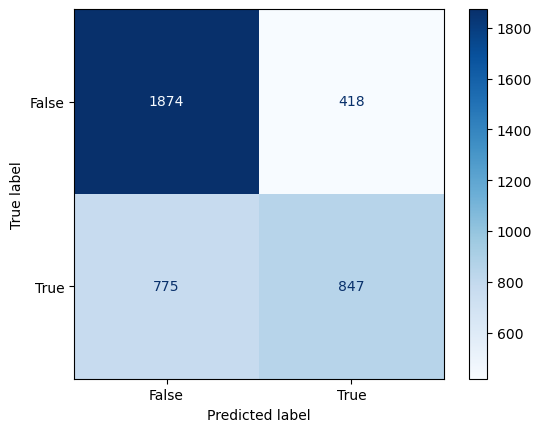

>> RF


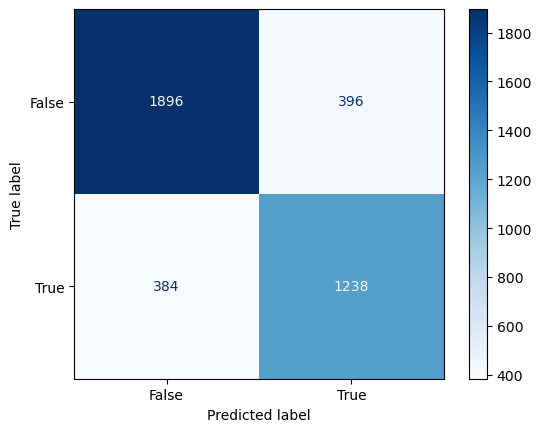

>> AB


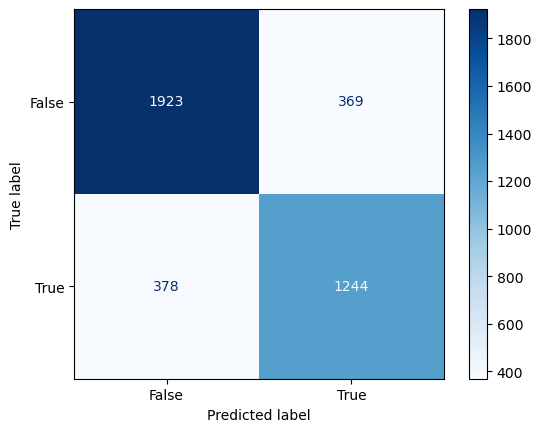

>> GB


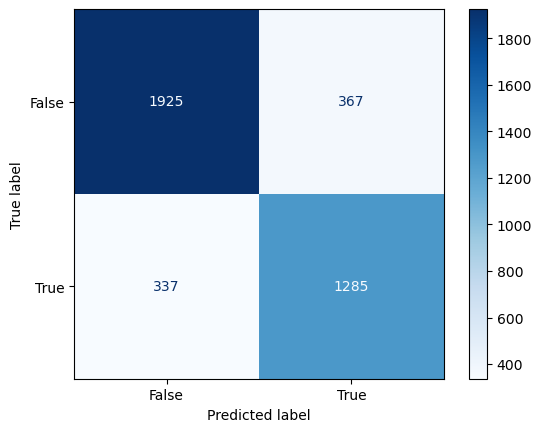

In [45]:
# On garde les memes modèles qu'avant avec les memes paramètres juste mnt on va faire des nouvelles instances de modelès pour fair l'apprentissage
models = [SVR(C= 0.1, kernel= 'rbf')]
models.append( RandomForestClassifier(max_depth = 10, min_samples_leaf = 4, min_samples_split= 10, n_estimators =  100))
models.append(AdaBoostClassifier(learning_rate= 1.0, n_estimators=200))
models.append(GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=200))

for index, model in enumerate(models):
    print(">> {}".format(names[index]))
    model.fit(X_train_new,y_train_new)
    y_pred_new = model.predict(X_test_new)
    plot_confusion_matrix(confusion_matrix(y_test_new, y_pred_new.round()))




In [65]:
########## d : à voir dans le rapport
########## e : à voir dans le rapport
########## f :

for index, best_model in enumerate(best_estimators):
    print(">> {}".format(names[index]))
    # selection_rate : Pour le training
    print("selection_rate : en train")
    y_pred_train = best_model.predict(X_train)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_train, y_pred=y_pred_train, sensitive_features=X_train['RAC1P'])
    print(metric_frame.by_group)
    
    # selection_rate : Pour le test
    print("selection_rate : en test")
    y_pred_test = best_model.predict(X_test)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_test, y_pred=y_pred_test, sensitive_features=X_test['RAC1P'])
    print(metric_frame.by_group)

    
    # equalized_odds_difference : Pour le training
    print("equalized_odds_difference : en train")
    y_pred_train = best_model.predict(X_train)
    y_true_mapped = np.array(y_train, dtype=int)
    y_pred_mapped = np.array(y_pred_train, dtype=int)
    metric_parity = equalized_odds_difference(y_true=y_true_mapped, y_pred=y_pred_mapped, sensitive_features=X_train['RAC1P'],method='between_groups')
    print(metric_parity)

    # equalized_odds_difference : Pour le test
    print("equalized_odds_difference : en test")
    y_pred_test = best_model.predict(X_test)
    y_true_mapped_ = np.array(y_test, dtype=int)
    y_pred_mapped_ = np.array(y_pred_test, dtype=int)
    metric_frame = equalized_odds_difference(y_true=y_true_mapped_, y_pred=y_pred_mapped_, sensitive_features=X_test['RAC1P'],method='between_groups')
    print(metric_parity)

>> SVM
selection_rate : en train
RAC1P
1.0    0.0
2.0    0.0
3.0    0.0
4.0    0.0
5.0    0.0
6.0    0.0
7.0    0.0
8.0    0.0
9.0    0.0
Name: selection_rate, dtype: float64
selection_rate : en test
RAC1P
1.0    0.0
2.0    0.0
3.0    0.0
5.0    0.0
6.0    0.0
7.0    0.0
8.0    0.0
9.0    0.0
Name: selection_rate, dtype: float64
equalized_odds_difference : en train
0.0
equalized_odds_difference : en test
0.0
>> RF
selection_rate : en train
RAC1P
1.0    0.444867
2.0    0.333797
3.0    0.315789
4.0    0.666667
5.0    0.076923
6.0    0.474186
7.0    0.253731
8.0    0.119821
9.0    0.342939
Name: selection_rate, dtype: float64
selection_rate : en test
RAC1P
1.0    0.444307
2.0    0.327586
3.0    0.269231
5.0    0.111111
6.0    0.506211
7.0    0.400000
8.0    0.123644
9.0    0.370370
Name: selection_rate, dtype: float64
equalized_odds_difference : en train
0.5714285714285714
equalized_odds_difference : en test
0.5714285714285714
>> AB
selection_rate : en train
RAC1P
1.0    0.446922
2.0    0

In [77]:
# On garde les memes modèles qu'avant avec les memes paramètres juste mnt on va faire des nouvelles instances de modelès pour fair l'apprentissage
models = [SVR(C= 0.1, kernel= 'rbf')]
models.append( RandomForestClassifier(max_depth = 10, min_samples_leaf = 4, min_samples_split= 10, n_estimators =  100))
models.append(AdaBoostClassifier(learning_rate= 1.0, n_estimators=200))
models.append(GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=200))

# Enlever la feature RAC1P du dataset
X_train.drop(columns=['RAC1P'], inplace=True)
X_test.drop(columns=['RAC1P'], inplace=True)
print(X_train)
print(X_train)

        AGEP  COW  SCHL  MAR    OCCP   POBP  RELP  WKHP  SEX
19956   48.0  7.0  19.0  1.0  4810.0    9.0   0.0  50.0  1.0
195030  56.0  1.0  21.0  1.0  4530.0   17.0   0.0  30.0  2.0
83681   34.0  7.0  21.0  3.0  4010.0    6.0  13.0  50.0  2.0
146586  69.0  6.0  23.0  3.0  1305.0   25.0   0.0  40.0  1.0
38293   73.0  1.0  16.0  5.0  2360.0  138.0   0.0  45.0  1.0
...      ...  ...   ...  ...     ...    ...   ...   ...  ...
35443   48.0  1.0  16.0  1.0   140.0  233.0   0.0  40.0  1.0
54156   28.0  1.0  16.0  3.0  7220.0    6.0   2.0  53.0  1.0
168973  28.0  1.0  18.0  1.0   310.0    6.0   0.0  48.0  1.0
2633    68.0  2.0  16.0  1.0   630.0  106.0  17.0  60.0  2.0
96943   24.0  1.0  21.0  5.0   440.0    6.0   2.0  40.0  1.0

[15652 rows x 9 columns]


>> SVM


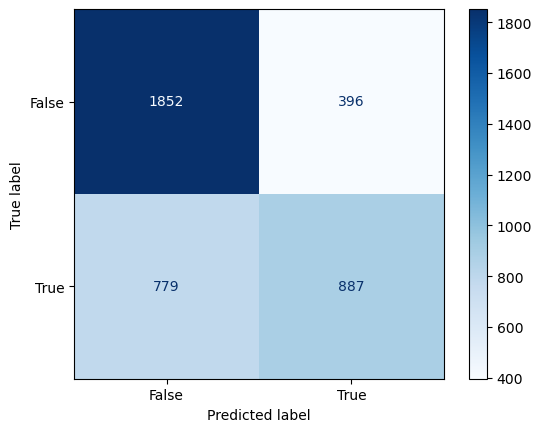

>> RF


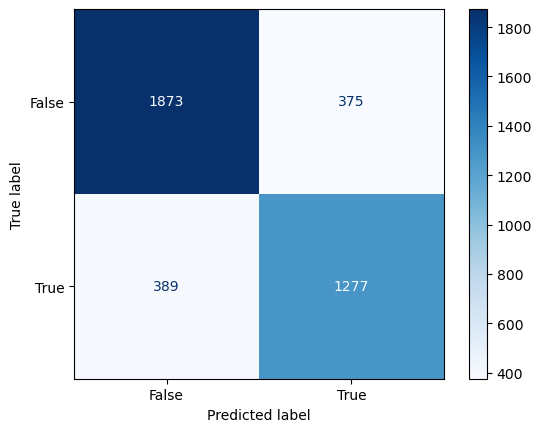

>> AB


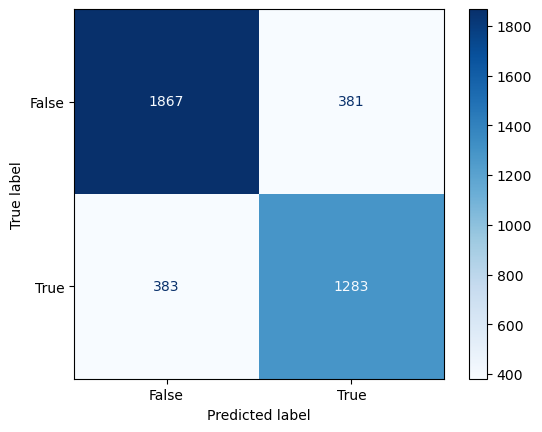

>> GB


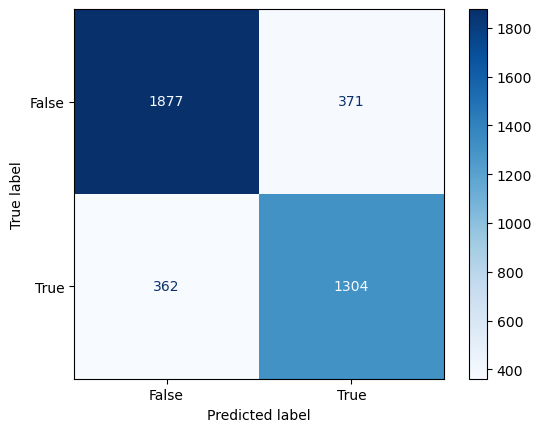

In [79]:
for index, model in enumerate(models):
    print(">> {}".format(names[index]))
    model.fit(X_train,y_train)
    y_pred_ = model.predict(X_test)
    plot_confusion_matrix(confusion_matrix(y_test, y_pred_.round()))